In [1]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [2]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [3]:
import numpy as np
import torch

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

nback_t = torch.from_numpy(nback).float().cuda()
emoid_t = torch.from_numpy(emoid).float().cuda()

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [4]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

print('Complete')

(620,)
(620, 2)
(620,)
Complete


In [10]:
n = 264
diag = torch.arange(0,n).long()
test = torch.zeros(120,n,n).float().cuda()
print(test[:,diag,diag].shape)
print(n-torch.sum(test[:,diag,diag], dim=1))

torch.Size([120, 264])
tensor([264., 264., 264., 264., 264., 264., 264., 264., 264., 264., 264., 264.,
        264., 264., 264., 264., 264., 264., 264., 264., 264., 264., 264., 264.,
        264., 264., 264., 264., 264., 264., 264., 264., 264., 264., 264., 264.,
        264., 264., 264., 264., 264., 264., 264., 264., 264., 264., 264., 264.,
        264., 264., 264., 264., 264., 264., 264., 264., 264., 264., 264., 264.,
        264., 264., 264., 264., 264., 264., 264., 264., 264., 264., 264., 264.,
        264., 264., 264., 264., 264., 264., 264., 264., 264., 264., 264., 264.,
        264., 264., 264., 264., 264., 264., 264., 264., 264., 264., 264., 264.,
        264., 264., 264., 264., 264., 264., 264., 264., 264., 264., 264., 264.,
        264., 264., 264., 264., 264., 264., 264., 264., 264., 264., 264., 264.],
       device='cuda:0')


In [249]:
import torch.nn as nn
import torch.nn.functional as F

class TVGL(nn.Module):
    def __init__(self, inp, ld, lam, beta):
        super(TVGL, self).__init__()
        self.eye = torch.eye(inp.shape[1]).float().cuda()
        self.ones = torch.ones(inp.shape[1],inp.shape[1]).float().cuda()
        self.thetas = 1/264*torch.rand(inp.shape[0],inp.shape[1],inp.shape[1]).float().cuda()
        self.thetas += torch.einsum('abc,adc->abd', self.thetas, self.thetas)
        self.thetas[:] += self.eye
        self.thetas = nn.Parameter(self.thetas)
        self.ld = ld
        self.lam = lam
        self.beta = beta
        
    def forward(self, S):
#         n = x.shape[1]
#         diag = torch.arange(0,n).long()
        n = S.shape[-1]
        sim = torch.sum((S-self.thetas)**2)
        diff = self.beta*torch.sum((self.thetas[1:]-self.thetas[:-1])**2)
#         S = torch.einsum('ab,ac->abc',x,x)
#         Stheta = torch.einsum('abc,adc->abd',self.thetas,S)
#         ld = self.ld*torch.sum((self.thetas-self.thetas.permute(0,2,1))**2)
#         trace = torch.sum((1-Stheta[:,diag,diag])**2)
#         l1 = self.lam*torch.sum(self.thetas**2)
#         l1 = self.lam*torch.sum(torch.abs((self.ones-self.eye).unsqueeze(0)*self.thetas))
#         diff = self.beta*torch.sum((self.thetas[1:]-self.thetas[:-1])**2)
        return [sim,diff]
    
nEpochs = 10000
pPeriod = 100

nt = nback_t.shape[-1]
X = nback_t[0].T
win = 10
cov = torch.zeros(nt-2*win,264,264).float().cuda()
for tp in range(win,nt-win):
    cov[tp-win] = X[tp-win:tp+win].T@X[tp-win:tp+win]

tvgl = TVGL(X[win:nt-win],ld=0,lam=0,beta=5e1)
optim = torch.optim.Adam(tvgl.parameters(), lr=5e-4, weight_decay=5e-4)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-6)

for epoch in range(nEpochs):
    loss = tvgl(cov)
    sum(loss).backward()
    optim.step()
    sched.step(loss[0])
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {[float(part) for part in loss]}')
        
print('Complete')

0 [150234.9375, 1761.090087890625]
100 [104154.765625, 253742.84375]
200 [75343.71875, 980871.6875]
300 [59179.875, 1801339.875]
400 [50177.2265625, 2603854.25]
500 [45343.69140625, 3329696.5]
600 [43607.078125, 4060252.25]
700 [42421.1171875, 4512235.0]
800 [41171.5078125, 4689899.0]
900 [36390.625, 4075458.5]
1000 [36551.85546875, 4243417.0]
1100 [31697.39453125, 3474704.0]
1200 [27263.3125, 2766111.25]
1300 [28368.71484375, 3001499.5]
1400 [26759.775390625, 2749295.75]
1500 [22648.435546875, 2058869.5]
1600 [18982.578125, 1443013.25]
1700 [17649.255859375, 1229662.75]
1800 [18154.890625, 1332039.25]
1900 [18436.23828125, 1393231.5]
2000 [18173.80078125, 1358315.25]
2100 [17632.900390625, 1273228.125]
2200 [16839.32421875, 1144590.375]
2300 [15893.68359375, 989326.9375]
2400 [14906.7060546875, 826122.625]
2500 [13963.89453125, 669658.5]
2600 [13123.9453125, 530181.375]
2700 [12421.9970703125, 413939.34375]
2800 [11874.4931640625, 323952.09375]
2900 [11484.11328125, 260837.921875]
300

torch.Size([264, 264])


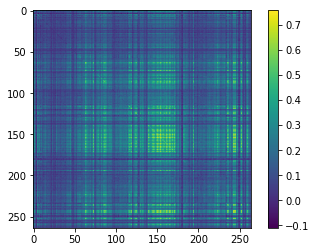

In [253]:
import matplotlib.pyplot as plt

sub = nback_t[0]
xx = torch.einsum('bc,bc->b',sub,sub).unsqueeze(0)
yy = xx.permute(1,0)
den = torch.sqrt(xx**2*yy**2)
print(den.shape)

# plt.imshow(den.detach().cpu().numpy())
plt.imshow(tvgl.thetas[90].detach().cpu().numpy())
# plt.imshow(torch.linalg.inv(tvgl.thetas[31]).detach().cpu().numpy())
plt.colorbar()
plt.show()

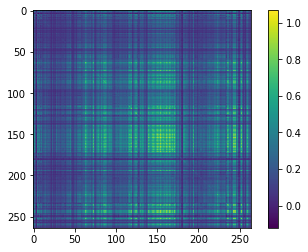

In [254]:
# testcorr = np.corrcoef(cov[30].detach().cpu().numpy())
# testcorrinv = np.linalg.inv(testcorr)

plt.imshow(cov[90].detach().cpu().numpy())
plt.colorbar()
plt.show()

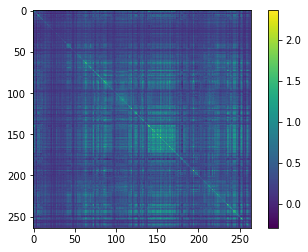

In [242]:
plt.imshow(nback[0]@nback[0].T)
plt.colorbar()
plt.show()